In [30]:
%%capture
import gzip
import operator, random

import numpy as np
import tensorflow as tf

from functools import reduce
from matplotlib import pyplot as plt

## Sparsity improves Model Compression
We use a randomly generated sample for this demonstration. We evaluate and compare the compression ratios achieved without and with sparsification. The expected outcome is higher compression ratio for the sparse model.

In [2]:
weights = np.random.random(size=(100, 100)).astype(np.float32)
sparsity_rate = 0.4 # The percentage of weights that are zeroed out.

# Sparsify the weights by setting a fraction of the weights to zero.
def sparsify_smallest(w, sr):
    w = w.copy()
    w_1d = np.reshape(w, -1)
    w_1d_sorted = np.sort(w_1d)
    threshold = w_1d_sorted[int(w_1d_sorted.size * sr)]

    # Set the weights to zero if they are less than the threshold.
    w[w < threshold] = 0

    return w

def compress_and_save(w):
    # Compress the weights matrix using gzip.
    compressed_w = gzip.compress(w.tobytes())
    return compressed_w

sparse_weights = sparsify_smallest(weights, sparsity_rate)

print('Original Size:', reduce(operator.mul, weights.shape)*weights.itemsize)

weights_compressed = compress_and_save(weights)
print('Original Compressed Size:', len(weights_compressed))

weights_sparsified_compressed = compress_and_save(sparse_weights)
print('Sparsified Compressed Size:', len(weights_sparsified_compressed))

Original Size: 40000
Original Compressed Size: 35928
Sparsified Compressed Size: 23944


## Sparsity induced compression in a logic gate classifier
This exercise is a step up from the previous example which used non-trainable weights. In this example, we will create a AND and OR gate datasets with labels -1 and 1 respectively. We will train a simple classifier to predict AND and OR gates. Next, we will conduct another round of training with induced sparsity in each training step. The expectation is that both the training procedures converge to comparable losses.

### Generate AND and OR gate dataset
The AND samples are labeled -1 and the OR samples get 1 label.

In [216]:
def make_dataset(count=100):
    def and_fn():
        samples = [((0, 0, 0), 1), ((0, 1, 0), 1), ((1, 0, 0), 1), ((1, 1, 1), 1)]
        return random.choice(samples)
    
    def or_fn():
        samples = [((0, 0, 0), -1), ((0, 1, 1), -1), ((1, 0, 1), -1), ((1, 1, 1), -1)]
        return random.choice(samples)

    def make_sample():
        sample_fn = and_fn if np.random.random() < 0.5 else or_fn
        return sample_fn()

    dataset = list(map(lambda _:  make_sample(), range(count)))
    return dataset

dataset = make_dataset()
X = np.array([x[0] for x in dataset]).astype(np.float32)
Y = np.array([x[1] for x in dataset]).astype(np.float32)

and_test_samples = tf.constant(np.array([(0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 1)]).astype('float32'))
# X, Y

Regular Training
--------------------------------
Step: 0  Loss: 2.3999939
Step: 1  Loss: 2.39999366
Step: 2  Loss: 2.39999342
Step: 3  Loss: 2.39999318
Step: 4  Loss: 2.39999294
Step: 5  Loss: 2.39999247
Step: 6  Loss: 2.39999199
Step: 7  Loss: 2.39999127
Step: 8  Loss: 2.39999104
Step: 9  Loss: 2.39999056
Step: 10  Loss: 2.39999
Step: 11  Loss: 2.3999896
Step: 12  Loss: 2.39998889
Step: 13  Loss: 2.39998817
Step: 14  Loss: 2.39998794
Step: 15  Loss: 2.39998698
Step: 16  Loss: 2.39998627
Step: 17  Loss: 2.39998555
Step: 18  Loss: 2.3999846
Step: 19  Loss: 2.39998364
Step: 20  Loss: 2.39998245
Step: 21  Loss: 2.39998174
Step: 22  Loss: 2.39998031
Step: 23  Loss: 2.39997935
Step: 24  Loss: 2.39997816
Step: 25  Loss: 2.39997649
Step: 26  Loss: 2.39997482
Step: 27  Loss: 2.39997339
Step: 28  Loss: 2.39997172
Step: 29  Loss: 2.39996958
Step: 30  Loss: 2.39996743
Step: 31  Loss: 2.39996529
Step: 32  Loss: 2.3999629
Step: 33  Loss: 2.3999598
Step: 34  Loss: 2.39995694
Step: 35  Loss: 2.39995

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[-0.20532076],
       [-0.20532076],
       [ 0.25336722],
       [ 0.25336722]], dtype=float32)>

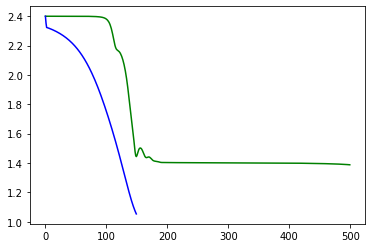

In [223]:
def evaluate(weights, X, Y):
    W1 = tf.Variable(weights[0])
    B1 = tf.Variable(weights[1])
    W2 = tf.Variable(weights[2])

def sparsify_smallest(weights, rate):
    def sparsify(w):
        w_1d = tf.reshape(w, -1)
        w_1d_sorted = tf.sort(w_1d)
        threshold = w_1d_sorted[int(w_1d_sorted.shape[0] * rate)]

        # Set the weights to zero if they are less than the threshold.
        w_below_threshold = tf.math.less(w_1d_sorted, threshold)
        w_below_threshold = tf.cast(w_below_threshold, tf.float32)
        w_below_threshold = tf.reshape(w_below_threshold, w.shape)
        w.assign(w * w_below_threshold)

        return w

    for w in weights:
        sparsify(w)

def compute_graph(x, W1, B1, W2, B2):
    Yp = tf.matmul(x, W1) + B1
    Yp = tf.nn.relu(Yp)
    Yp = tf.matmul(Yp, W2) + B2
    Yp = tf.tanh(Yp)

    return Yp

def train(steps=100, sparsify=False, sparsity_rate=0.4):
    tf.random.set_seed(11)

    W1 = tf.Variable(tf.random.normal((3, 30)))
    B1 = tf.Variable(tf.squeeze(tf.random.normal([30])))

    W2 = tf.Variable(tf.random.normal((30, 1)))
    B2 = tf.Variable(tf.squeeze(tf.random.normal([1])))

    opt = tf.keras.optimizers.Adam()
    loss = None
    losses = []

    for step_id in range(steps):
        with tf.GradientTape(persistent=True) as tape:
            Yp = compute_graph(X, W1, B1, W2, B2)
            loss = tf.reduce_mean(tf.square(Yp - Y))

        gradients = tape.gradient(loss, [W1, B1, W2, B2])
        opt.apply_gradients(zip(gradients, [W1, B1, W2, B2]))

        sparsify_smallest([W1, B1, W2], sparsity_rate) if sparsify else None

        tf.print('Step:', step_id, ' Loss:', loss)
        losses.append(loss.numpy())
    
    return W1, B1, W2, B2, losses

print('Regular Training')
print('--------------------------------')
W1, B1, W2, B2, losses = train(steps=500)
plt.plot(losses, c='g', label='Regular')
predictions = compute_graph(and_test_samples, W1, B1, W2, B2)
predictions

print('Sparsified Training')
print('--------------------------------')
W1, B1, W2, B2, losses_sparse = train(steps=500, sparsify=True)
plt.plot(losses_sparse, c='b', label='Sparsified')
predictions = compute_graph(and_test_samples, W1, B1, W2, B2)
predictions

# plt.plot(losses, c='g', label='Regular')
# plt.plot(losses_sparse, c='b', label='Sparsified')

# plt.title('Per Traning Step Losses')
# plt.xlabel('Steps')
# plt.ylabel('Loss Values')
# plt.legend()


In [212]:
and_test_samples = tf.constant(np.array([(0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 1)]).astype('float32'))

# or_test_samples = [(0, 0, 0), (0, 1, 1), (1, 0, 1), (1, 1, 1)]
# and_test_samples

def compute_graph(x, W1, B1, W2, B2):
    Yp = tf.matmul(x, W1) + B1
    Yp = tf.nn.relu(Yp)
    Yp = tf.matmul(Yp, W2) + B2
    Yp = tf.tanh(Yp)

    return Yp

tf.random.set_seed(11)

W1 = tf.Variable(tf.random.normal((3, 100)))
B1 = tf.Variable(tf.squeeze(tf.random.normal([100])))

W2 = tf.Variable(tf.random.normal((100, 1)))
B2 = tf.Variable(tf.squeeze(tf.random.normal([1])))

predictions = compute_graph(and_test_samples, W1, B1, W2, B2)
predictions





<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.9999996 ],
       [0.99999994],
       [0.99999994],
       [0.99999994]], dtype=float32)>

## Let's play CartPole

In [2]:
%%capture
! pip install gym

In [14]:
# simple neural network implementation of qlearning
import gym
from gym import wrappers 
import numpy as np
import tensorflow as tf

# build environment
env = gym.make("FrozenLake-v1")
# env = wrappers.Monitor(env, '/tmp/frozenlake-qlearning', force=True)
n_obv = env.observation_space.n
n_acts = env.action_space.n

# initialization 
learning_rate = 0.1 
gamma = 0.99 
train_episodes = 10000
episodes = 0 
prev_state = env.reset() 
episode_t = 0
e = 0.1 

# create model
x = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.1))
out = tf.matmul(x, W)
act = tf.argmax(out, 1)
t = tf.placeholder(shape=[1, 4], dtype = tf.float32)
loss = tf.reduce_sum(tf.square(t - out))
train_step = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

# start session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

while episodes < train_episodes: 
    episode_t += 1
    # take noisy action 
    action, qvalues = sess.run([act, out], feed_dict={x: np.identity(16)[prev_state:prev_state + 1]})
    if (np.random.rand(1)) < e: 
        action[0] = env.action_space.sample()
    next_state, rew, done, _ = env.step(action[0])

    # find targetQ values and update model
    qnext_values = sess.run([out], feed_dict={x: np.identity(16)[next_state:next_state + 1]})
    max_q = np.max(qnext_values)
    targetq = qvalues 
    targetq[0, action[0]] = rew + gamma * max_q
    sess.run([train_step], feed_dict={x: np.identity(16)[prev_state:prev_state + 1], t: targetq})
    prev_state = next_state

    # episode finished
    if done: 
        episodes += 1
        # decrease noise as number of episodes increases
        e = 1./((episodes/50) + 10)
        prev_state = env.reset()
        print ("episode %d finished after %d timesteps, rew = %d" % (episodes, episode_t, rew))
        episode_t = 0

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [ ]:
ENV = gym.make("FrozenLake-v1")
N_STATES = ENV.observation_space.n
N_ACTIONS = ENV.action_space.n

# initialization 
LEARNING_RATE = 0.1 
GAMMA = 0.99 
N_EPISODES = 1000


# create model
x = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.1))
out = tf.matmul(x, W)
act = tf.argmax(out, 1)
t = tf.placeholder(shape=[1, 4], dtype = tf.float32)
loss = tf.reduce_sum(tf.square(t - out))
train_step = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

# start session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

def train(steps=5):
    Qo = tf.zeros((1, N_STATES))
    W = tf.Variable(tf.random.uniform([N_STATES, N_ACTIONS]))

    opt = tf.keras.optimizers.Adam()
    loss = None
    losses = []

    for step_idx in range(steps):
        with tf.GradientTape() as tape:
            Q = tf.matmul(Qo, W)
            prediction = tf.argmax(Q, 1)
            loss = tf.reduce_sum(tf.square(nextQ - Q))
        
        gradients = tape.gradient(loss, W)
        opt.apply_gradients(zip(gradients, [W]))

        tf.print('Step:', step_idx, ' Loss:', loss)
        losses.append(loss.numpy())
    
    return losses

train()
    


In [ ]:
# simple neural network implementation of qlearning
import gym
from gym import wrappers 
import numpy as np
import tensorflow as tf

# build environment
env = gym.make("FrozenLake-v1")
# env = wrappers.Monitor(env, '/tmp/frozenlake-qlearning', force=True)
n_obv = env.observation_space.n
n_acts = env.action_space.n

# initialization 
learning_rate = 0.1 
gamma = 0.99 
train_episodes = 10000
episodes = 0 
prev_state = env.reset() 
episode_t = 0
e = 0.1 

# create model
x = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.1))
out = tf.matmul(x, W)
act = tf.argmax(out, 1)
t = tf.placeholder(shape=[1, 4], dtype = tf.float32)
loss = tf.reduce_sum(tf.square(t - out))
train_step = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

# start session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

while episodes < train_episodes: 
    episode_t += 1
    # take noisy action 
    action, qvalues = sess.run([act, out], feed_dict={x: np.identity(16)[prev_state:prev_state + 1]})
    if (np.random.rand(1)) < e: 
        action[0] = env.action_space.sample()
    next_state, rew, done, _ = env.step(action[0])

    # find targetQ values and update model
    qnext_values = sess.run([out], feed_dict={x: np.identity(16)[next_state:next_state + 1]})
    max_q = np.max(qnext_values)
    targetq = qvalues 
    targetq[0, action[0]] = rew + gamma * max_q
    sess.run([train_step], feed_dict={x: np.identity(16)[prev_state:prev_state + 1], t: targetq})
    prev_state = next_state

    # episode finished
    if done: 
        episodes += 1
        # decrease noise as number of episodes increases
        e = 1./((episodes/50) + 10)
        prev_state = env.reset()
        print ("episode %d finished after %d timesteps, rew = %d" % (episodes, episode_t, rew))
        episode_t = 0

In [18]:
from tensorflow.keras import layers, initializers, models
from tensorflow import keras

def construct_q_network(state_dim, action_dim):
    """Construct the q-network with q-values per action as output"""
    inputs = layers.Input(shape=(state_dim,))  # input dimension
    hidden1 = layers.Dense(
        25, activation="relu",)(inputs)
    hidden2 = layers.Dense(
        25, activation="relu", kernel_initializer=initializers.he_normal()
    )(hidden1)
    hidden3 = layers.Dense(
        25, activation="relu", kernel_initializer=initializers.he_normal()
    )(hidden2)
    q_values = layers.Dense(
        action_dim, kernel_initializer=initializers.Zeros(), activation="linear"
    )(
        hidden3
    )

    q_network = keras.Model(inputs=inputs, outputs=[q_values])

    return q_network

q_network = construct_q_network()



TypeError: construct_q_network() missing 2 required positional arguments: 'state_dim' and 'action_dim'


======episode 0 ======
Q-values ['0.000', '0.000', '0.000', '0.000']
Rel. deviation ['-1.000', '-1.000', '-1.000', '-1.000']

======episode 1000 ======
Q-values ['0.898', '1.280', '0.972', '1.612']
Rel. deviation ['-0.002', '0.066', '0.388', '0.612']

======episode 2000 ======
Q-values ['1.084', '1.279', '0.798', '0.775']
Rel. deviation ['0.205', '0.066', '0.140', '-0.225']

======episode 3000 ======
Q-values ['0.721', '1.082', '0.345', '0.764']
Rel. deviation ['-0.199', '-0.098', '-0.507', '-0.236']

======episode 4000 ======
Q-values ['0.929', '1.127', '0.744', '0.790']
Rel. deviation ['0.032', '-0.061', '0.063', '-0.210']

======episode 5000 ======
Q-values ['0.842', '1.191', '0.791', '0.724']
Rel. deviation ['-0.064', '-0.007', '0.130', '-0.276']

======episode 6000 ======
Q-values ['0.587', '1.212', '0.880', '1.045']
Rel. deviation ['-0.348', '0.010', '0.257', '0.045']

======episode 7000 ======
Q-values ['0.747', '1.065', '0.637', '0.878']
Rel. deviation ['-0.170', '-0.112', '-0

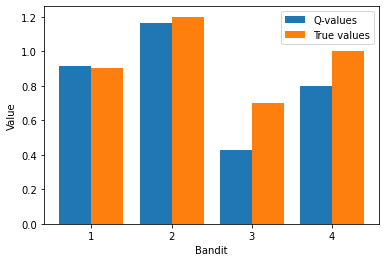

In [19]:
# Needed for training the network
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.initializers as initializers

# Needed for animation
import matplotlib.pyplot as plt

def get_reward(bandit: float) -> tf.Tensor:
    """Generate reward for selected bandit"""
    reward = tf.random.normal([1], mean=bandit, stddev=1, dtype=tf.dtypes.float32)

    return reward


def plot(q_values: tf.Tensor, bandits: np.array) -> None:
    """Plot bar chart with selection probability per bandit"""
    q_values_plot = [
        q_values[0],
        q_values[1],
        q_values[2],
        q_values[3],
    ]
    bandit_plot = [
        bandits[0],
        bandits[1],
        bandits[2],
        bandits[3],
    ]
    width = 0.4
    x = np.arange(len(bandits))
    fig, ax = plt.subplots()
    ax.bar(x - width / 2, q_values_plot, width, label="Q-values")
    ax.bar(x + width / 2, bandit_plot, width, label="True values")

    # Add labels and legend
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(["1", "2", "3", "4"])

    plt.xlabel("Bandit")
    plt.ylabel("Value")
    plt.legend(loc="best")

    plt.show()

    return


def construct_q_network(state_dim: int, action_dim: int) -> keras.Model:
    """Construct the critic network with q-values per action as output"""
    inputs = layers.Input(shape=(state_dim,))  # input dimension
    hidden1 = layers.Dense(
        10, activation="relu", kernel_initializer=initializers.he_normal()
    )(inputs)
    hidden2 = layers.Dense(
        10, activation="relu", kernel_initializer=initializers.he_normal()
    )(hidden1)
    hidden3 = layers.Dense(
        10, activation="relu", kernel_initializer=initializers.he_normal()
    )(hidden2)
    q_values = layers.Dense(
        action_dim, kernel_initializer=initializers.Zeros(), activation="linear"
    )(hidden3)

    deep_q_network = keras.Model(inputs=inputs, outputs=[q_values])

    return deep_q_network


def mean_squared_error_loss(q_value: tf.Tensor, reward: tf.Tensor) -> tf.Tensor:
    """Compute mean squared error loss"""
    loss = 0.5 * (q_value - reward) ** 2

    return loss


if __name__ == "__main__":
    # Initialize parameters
    state = tf.constant([[1]])
    bandits = np.array([0.9, 1.2, 0.7, 1.0])
    state_dim = len(state)
    action_dim = len(bandits)
    exploration_rate = 0.1
    learning_rate = 0.01
    num_episodes = 10000

    # Construct Q-network
    q_network = construct_q_network(state_dim, action_dim)

    # Define optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    for i in range(num_episodes + 1):
        with tf.GradientTape() as tape:
            # Obtain Q-values from network
            q_values = q_network(state)

            epsilon = np.random.rand()
            if epsilon <= exploration_rate:
                # Select random action
                action = np.random.choice(len(bandits))
            else:
                # Select action with highest q-value
                action = np.argmax(q_values)

            # Obtain reward from bandit
            reward = get_reward(bandits[action])

            # Obtain Q-value
            q_value = q_values[0, action]

            # Compute loss value
            loss_value = mean_squared_error_loss(q_value, reward)

            # Compute gradients
            grads = tape.gradient(loss_value[0], q_network.trainable_variables)

            # Apply gradients to update network weights
            opt.apply_gradients(zip(grads, q_network.trainable_variables))

            # Print console output
            if np.mod(i, 1000) == 0:
                print("\n======episode", i, "======")
                print("Q-values", ["%.3f" % n for n in q_values[0]])
                print(
                    "Rel. deviation",
                    [
                        "%.3f" % float((q_values[0, i] - bandits[i]) / bandits[i])
                        for i in range(len(q_values[0]))
                    ],
                )

    # Plot Q-values
    plot(q_values[0], bandits)

In [29]:
# Needed for training the network
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.initializers as initializers

# Needed for animation
import matplotlib.pyplot as plt

def get_reward(bandit: float) -> tf.Tensor:
    """Generate reward for selected bandit"""
    reward = tf.random.normal([1], mean=bandit, stddev=1, dtype=tf.dtypes.float32)

    return reward

def construct_q_network(state_dim, action_dim):
    """Construct the critic network with q-values per action as output"""
    inputs = layers.Input(shape=(state_dim))  # input dimension
    hidden1 = layers.Dense(10, activation="relu")(inputs)
    hidden2 = layers.Dense(10, activation="relu")(hidden1)
    hidden3 = layers.Dense(10, activation="relu")(hidden2)
    q_values = layers.Dense(action_dim)(hidden3)

    deep_q_network = keras.Model(inputs=inputs, outputs=[q_values])

    return deep_q_network


def mean_squared_error_loss(q_value, reward):
    """Compute mean squared error loss"""
    loss = 0.5 * (q_value - reward) ** 2

    return loss

ENV = gym.make("FrozenLake-v1")
N_STATES = ENV.observation_space.n
N_ACTIONS = ENV.action_space.n
N_EPISODES = 5
EXPLORATION_RATE = .1

print(N_STATES, N_ACTIONS, N_EPISODES, EXPLORATION_RATE)
model = construct_q_network(N_STATES, N_ACTIONS)
opt = tf.keras.optimizers.Adam()

state = tf.expand_dims(tf.one_hot(ENV.reset(), N_STATES, dtype=tf.float32), 0)
print(state)

for ep_idx in range(N_EPISODES):
    with tf.GradientTape() as tape:
        q_values = model(state)

        # Choose between the greey move or the random move.
        # Greedy move take the greedy approach to chose the best current action.
        epsilon = np.random.rand()
        if epsilon <= EXPLORATION_RATE:
            action = np.random.choice(N_ACTIONS)
        else:
            action = np.argmax(q_values)
        
        # Take the action and get the next state and reward.
        next_state, reward, done, _ = ENV.step(action)
        print(next_state, reward, done)

        # Convert the next state to one-hot encoding.
        next_state = tf.expand_dims(tf.one_hot(next_state, N_STATES, dtype=tf.float32), 0)
        print(next_state)

        # Compute Q(s,a) and Q(s',a').
        q_s_a = model(state)
        q_s_a_next = model(next_state)

        # Compute the target Q-value.



        # Compute the loss.


        loss = mean_squared_error_loss(q_values[0], reward)
        





# if __name__ == "__main__":
#     # Initialize parameters
#     state = tf.constant([[1]])
#     bandits = np.array([0.9, 1.2, 0.7, 1.0])
#     state_dim = len(state)
#     action_dim = len(bandits)
#     exploration_rate = 0.1
#     learning_rate = 0.01
#     num_episodes = 10000

#     # Construct Q-network
#     q_network = construct_q_network(state_dim, action_dim)

#     # Define optimizer
#     opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

#     for i in range(num_episodes + 1):
#         with tf.GradientTape() as tape:
#             # Obtain Q-values from network
#             q_values = q_network(state)

#             epsilon = np.random.rand()
#             if epsilon <= exploration_rate:
#                 # Select random action
#                 action = np.random.choice(len(bandits))
#             else:
#                 # Select action with highest q-value
#                 action = np.argmax(q_values)

#             # Obtain reward from bandit
#             reward = get_reward(bandits[action])

#             # Obtain Q-value
#             q_value = q_values[0, action]

#             # Compute loss value
#             loss_value = mean_squared_error_loss(q_value, reward)

#             # Compute gradients
#             grads = tape.gradient(loss_value[0], q_network.trainable_variables)

#             # Apply gradients to update network weights
#             opt.apply_gradients(zip(grads, q_network.trainable_variables))

#             # Print console output
#             if np.mod(i, 1000) == 0:
#                 print("\n======episode", i, "======")
#                 print("Q-values", ["%.3f" % n for n in q_values[0]])
#                 print(
#                     "Rel. deviation",
#                     [
#                         "%.3f" % float((q_values[0, i] - bandits[i]) / bandits[i])
#                         for i in range(len(q_values[0]))
#                     ],
#                 )

#     # Plot Q-values
#     plot(q_values[0], bandits)

16 4 5 0.1
tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 16), dtype=float32)
4 0.0 False
tf.Tensor([[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 16), dtype=float32)
4 0.0 False
tf.Tensor([[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 16), dtype=float32)
4 0.0 False
tf.Tensor([[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 16), dtype=float32)
4 0.0 False
tf.Tensor([[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 16), dtype=float32)
4 0.0 False
tf.Tensor([[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 16), dtype=float32)


In [31]:
# simple neural network implementation of qlearning
import gym

# build environment
env = gym.make("FrozenLake-v1")
env.reset()

0